In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import mpl_toolkits.mplot3d.axes3d as p3

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

from datafold.pcfold import PCManifold, TSCDataFrame 
from datafold.pcfold.kernels import GaussianKernel

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Prepare train and test data
batch_size = 6

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR10(root='./data', 
                            train=True,
                            download=True, 
                            transform=transform)

trainloader = DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


testset = datasets.CIFAR10(root='./data',
                           train=False,
                           download=True,
                           transform=transform)

testloader = DataLoader(testset,
                        batch_size=batch_size,
                        shuffle=False, num_workers=2)

# constant for classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Visualize Data

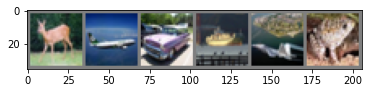

 deer plane   car  ship plane  frog


In [44]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [45]:
images = images.reshape((6, 3, -1))
images_1 = images[0].T
images_2 = images[1].T

In [48]:
pcm = PCManifold(images_1, kernel=GaussianKernel(epsilon=4), dist_kwargs=dict(cut_off=6, backend="guess_optimal"))

isinstance(pcm, np.ndarray)=True


kernel=GaussianKernel(epsilon=4) | dist_kwargs={'cut_off': 6, 'backend': 'guess_optimal'}
PCManifold([[-0.7176471 , -0.5058824 , -0.5686275 ],
            [-0.7882353 , -0.58431375, -0.6313726 ],
            [-0.7254902 , -0.5686275 , -0.62352943],
            ...,
            [ 0.3803922 ,  0.52156866,  0.05882359],
            [ 0.3411765 ,  0.5058824 ,  0.02745104],
            [ 0.36470592,  0.5372549 ,  0.05098045]], dtype=float32)

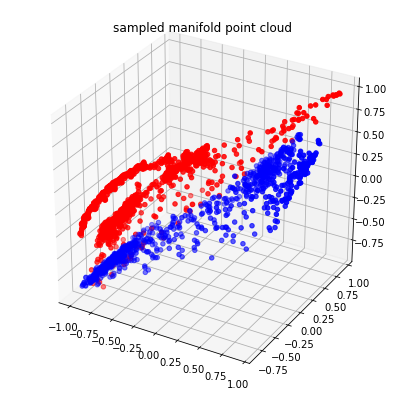

In [49]:
# plot
fig = plt.figure(figsize=[7, 7])
ax = fig.add_subplot(1, 1, 1, projection="3d")
ax.scatter(*images_1.T, c='b', cmap=plt.cm.Spectral)
ax.scatter(*images_2.T, c='r', cmap=plt.cm.Spectral)
ax.set_title("sampled manifold point cloud");

print(f"isinstance(pcm, np.ndarray)={isinstance(pcm, np.ndarray)}" )
pcm  # displays the data